In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Regresión Logística

## Titanic
Vamos a crear un modelo que prediga la probabilidad de supervivencia de los pasajeros

https://www.kaggle.com/c/titanic/data?select=train.csv

0. Importar data de training y testing. Agregarle a la tabla de testing la columna survived proveniente de la tabla gender_submission

In [2]:
train_data = pd.read_csv("Titanic/train.csv")
test_data = pd.read_csv("Titanic/test.csv")

In [3]:
resultados = pd.read_csv("Titanic/gender_submission.csv")
resultados.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [4]:
test_data.shape

(418, 11)

In [5]:
test_data = test_data.merge(resultados, how = "left")
test_data.shape

(418, 12)

1. Buscar columnas con valores nulos y cantidad de nulos en cada una. Fijarse el porcentaje de los datos nulos que representan sobre el total.

In [6]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64

In [8]:
total_filas = train_data.shape[0]
print(f"La columna Age tiene un {177/total_filas*100}%")
print(f"La columna Cabin tiene un {687/total_filas*100}%")
print(f"La columna Embarked tiene un {2/total_filas*100}%")

La columna Age tiene un 19.865319865319865%
La columna Cabin tiene un 77.10437710437711%
La columna Embarked tiene un 0.22446689113355783%


2. En base al resultado anterior. Cuales columnas consideran que tienen sentido completar y cuales se deberían eliminar? Eliminar la que corresponda de la tabla de test y de train.

In [9]:
# se debería eliminar la columna Cabin y completar las otras dos
train_data.drop("Cabin", axis = "columns", inplace = True)
test_data.drop("Cabin", axis = "columns", inplace = True)

3. Completar valores nulos con el criterio que considres correcto en cada una de las columnas (que tengan sentido completar). Esto debe hacerse tanto en la tabla de training como la de testing (con el mismo criterio en ambas).

   Verificar como se distribuyen los valores de cada columna con un gráfico previamente para tener más herramientas en la decisión

<Axes: xlabel='Age', ylabel='Count'>

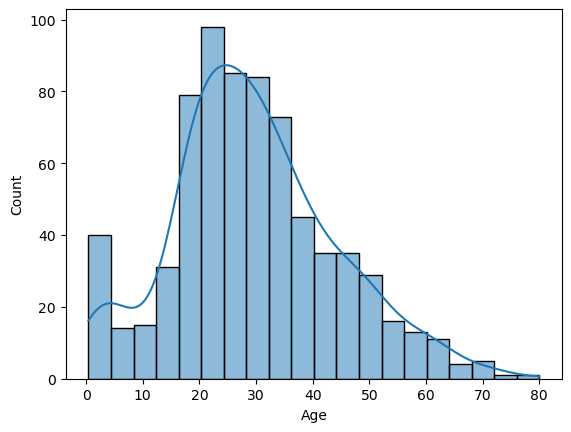

In [10]:
# Verifico como se distribuyen las edades
sns.histplot(train_data["Age"], kde = True)

In [11]:
print(train_data["Age"].median())
print(train_data["Age"].mean())

28.0
29.69911764705882


In [12]:
# age -> completo con la edad mediana
train_data["Age"].fillna(
    train_data["Age"].median(), 
    inplace=True
)

test_data["Age"].fillna(
    test_data["Age"].median(), 
    inplace=True
)

<Axes: xlabel='Embarked', ylabel='PassengerId'>

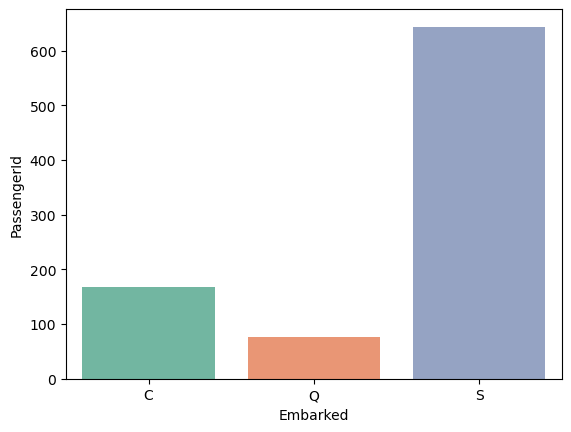

In [13]:
# Verifico como se distribuyen la columna Embarked
embarked = train_data.groupby("Embarked").agg({"PassengerId":"count"}).reset_index()
sns.barplot(x=embarked["Embarked"], y=embarked["PassengerId"], hue = embarked["Embarked"], palette='Set2')

In [14]:
# completo con el valor que más se repite, que es la "S"
train_data["Embarked"].fillna(
    train_data['Embarked'].value_counts().idxmax(), 
    inplace=True
)

In [15]:
# Verifico como se distribuyen los fare en testing
# es un único valor por lo que voy a verlo particularmente
test_data.loc[test_data["Fare"].isnull(),:]



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,0


In [16]:
# Al ser de tercera clase, le voy a asignar el precio promedio de tercera clase
promedio = test_data.loc[test_data["Pclass"] == 3,"Fare"].mean()

test_data["Fare"].fillna(
    promedio, 
    inplace=True
)

4. Realizar análisis exploratorio. Graficar las personas que sobrevivieron por:
    - Clase (Pclass)
    - Sexo (Sex)
    - Costo de boleto (Fare)

<Axes: xlabel='Pclass', ylabel='Survived'>

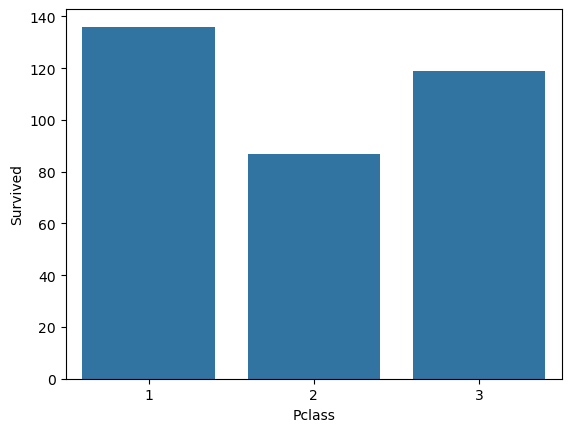

In [17]:
data_plot = train_data.groupby("Pclass").agg({"Survived":"sum"}).reset_index()
sns.barplot(x=data_plot["Pclass"], y=data_plot["Survived"])

<Axes: xlabel='Sex', ylabel='Survived'>

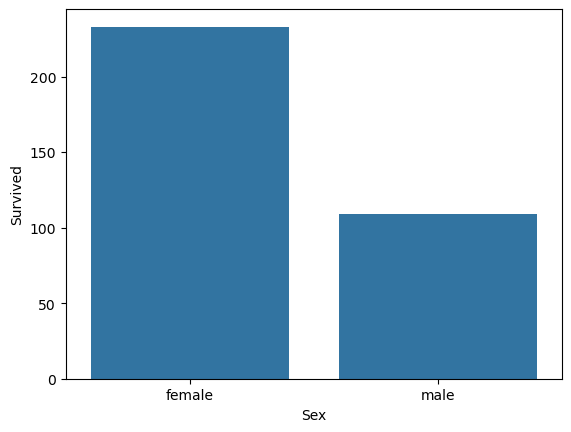

In [18]:
data_plot = train_data.groupby("Sex").agg({"Survived":"sum"}).reset_index()
sns.barplot(x=data_plot["Sex"], y=data_plot["Survived"])

(0.0, 200.0)

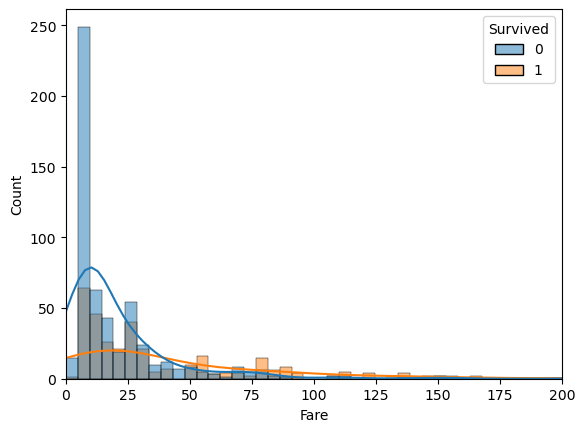

In [19]:
sns.histplot(x=train_data["Fare"], hue=train_data["Survived"],kde =True)
plt.xlim((0,200))

5. Verificar columnas del DataFrame e identificar sobre cuales se deberían generar variables dummies.
   Generar columnas de dummies sobre "Pclass","Embarked" y "Sex". Aplicar cambios en training y testing

In [20]:
test_data = pd.get_dummies(
    test_data, 
    columns=["Pclass","Embarked","Sex"],
    drop_first = True
)

train_data = pd.get_dummies(
    train_data, 
    columns=["Pclass","Embarked","Sex"],
    drop_first = True
)

In [21]:
test_data.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Survived,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,0,False,True,True,False,True
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,1,False,True,False,True,False
2,894,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,0,True,False,True,False,True
3,895,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,0,False,True,False,True,True
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,1,False,True,False,True,False


6. Eliminar columnas del dataset que considere que no suman al modelo. Hacerlo en testing y training

In [22]:
train_data.drop('PassengerId', axis=1, inplace=True)
train_data.drop('Name', axis=1, inplace=True)
train_data.drop('Ticket', axis=1, inplace=True)

test_data.drop('PassengerId', axis=1, inplace=True)
test_data.drop('Name', axis=1, inplace=True)
test_data.drop('Ticket', axis=1, inplace=True)

7. Agregar una columna llamada "IsMinor" que sea 1 en caso de tener 16 años o menos y 0 en caso contrario. Hacerlo para testing y training

In [23]:
train_data['IsMinor']=np.where(train_data['Age']<=16, 1, 0)
test_data['IsMinor']=np.where(test_data['Age']<=16, 1, 0)

In [24]:
train_data.columns

Index(['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3',
       'Embarked_Q', 'Embarked_S', 'Sex_male', 'IsMinor'],
      dtype='object')

8. Ajustar modelo considerando todas las variables del dataset de testing.

In [25]:
from sklearn import neighbors

X_train = train_data.loc[:,train_data.columns != "Survived"]
y_train = train_data["Survived"]

# Utilizar KNN para determinar los vecinos más cercanos
k = 5
modelo = neighbors.KNeighborsClassifier(n_neighbors=k)
modelo.fit(X_train, y_train)

KNeighborsClassifier()

9. Validar el modelo con datos de testing, agregar columna con cluster a test_data

In [26]:
X_test = test_data.loc[:,test_data.columns != "Survived"]
y_real = test_data["Survived"]

test_data["y_pred"] = modelo.predict(X_test) 
test_data.head()

,Age,SibSp,Parch,Fare,Survived,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,IsMinor,y_pred
0,34.5,0,0,7.8292,0,False,True,True,False,True,0,0
1,47.0,1,0,7.0000,1,False,True,False,True,False,0,0
2,62.0,0,0,9.6875,0,True,False,True,False,True,0,0
3,27.0,0,0,8.6625,0,False,True,False,True,True,0,1
4,22.0,1,1,12.2875,1,False,True,False,True,False,0,0


10. Calcular matriz de confusión

In [27]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [28]:
matriz_confusion = confusion_matrix(test_data["Survived"], test_data["y_pred"])
matriz_confusion

array([[192,  74],
       [ 71,  81]], dtype=int64)

In [29]:
test_data.groupby(["y_pred", "Survived"]).size()

y_pred  Survived
0       0           192
        1            71
1       0            74
        1            81
dtype: int64

11. Calcular Accuracy

In [30]:
(matriz_confusion[0][0] + matriz_confusion[1][1])/ matriz_confusion.sum()

0.65311004784689

12. Calcular sensibilidad

In [31]:
(matriz_confusion[1][1])/(matriz_confusion[1][1] + matriz_confusion[1][0])

0.5328947368421053

13. Calcular especificidad

In [32]:
(matriz_confusion[0][0])/(matriz_confusion[0][0] + matriz_confusion[0][1])

0.7218045112781954